# Electro cardiogram prediction using CNN and LSTM and the hybridization of both 

### Dataset link

https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data

In [65]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, label_binarize
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve
from sklearn.feature_selection import mutual_info_classif

In [13]:
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./dataset\archive (8).zip
./dataset\mitbih_test.csv
./dataset\mitbih_train.csv
./dataset\ptbdb_abnormal.csv
./dataset\ptbdb_normal.csv


In [14]:
train_data = pd.read_csv('./dataset/mitbih_train.csv', header=None)
test_data = pd.read_csv('./dataset/mitbih_test.csv', header=None)

In [34]:
# Join the datasets
df = pd.concat([train_data, test_data], axis=0)

# Resetting the index if needed
df.reset_index(drop=True, inplace=True)

# display the first few rows of the combined dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
df.shape

(109446, 188)

In [35]:
df.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

In [37]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Calculate Information Gain
info_gain = mutual_info_classif(X, y, discrete_features='auto')

# Create a DataFrame to display features and their corresponding Information Gain
info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})

# Sort the DataFrame based on Information Gain values
info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)

# Display the top features based on Information Gain
print("Top features based on Information Gain:")
print(info_gain_df.head(10))  # Display top 10 features

# Select features with Information Gain above a certain threshold if needed
threshold = 0.01 
relevant_features = info_gain_df[info_gain_df['Information Gain'] > threshold]

print("\nRelevant features based on threshold:")
print(relevant_features)

Top features based on Information Gain:
    Feature  Information Gain
3         3          0.174795
4         4          0.155920
5         5          0.136163
2         2          0.120900
45       45          0.117397
99       99          0.117004
46       46          0.116544
47       47          0.116368
44       44          0.115642
98       98          0.115117

Relevant features based on threshold:
     Feature  Information Gain
3          3          0.174795
4          4          0.155920
5          5          0.136163
2          2          0.120900
45        45          0.117397
..       ...               ...
170      170          0.011779
183      183          0.011613
186      186          0.010843
180      180          0.010522
184      184          0.010354

[185 rows x 2 columns]


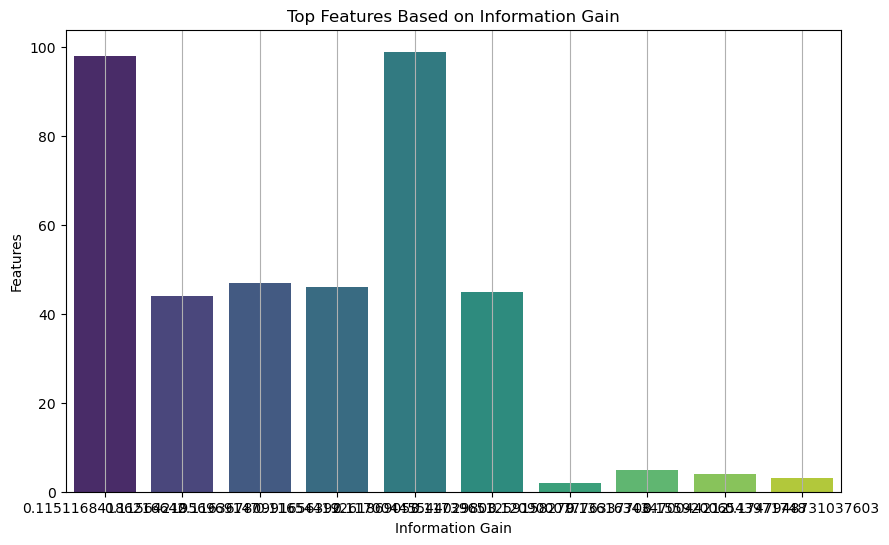

In [38]:
# Select top features for visualization
top_n = 10  # You can adjust this number
top_features = info_gain_df.head(top_n)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Information Gain', y='Feature', data=top_features, palette='viridis')
plt.title('Top Features Based on Information Gain')
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

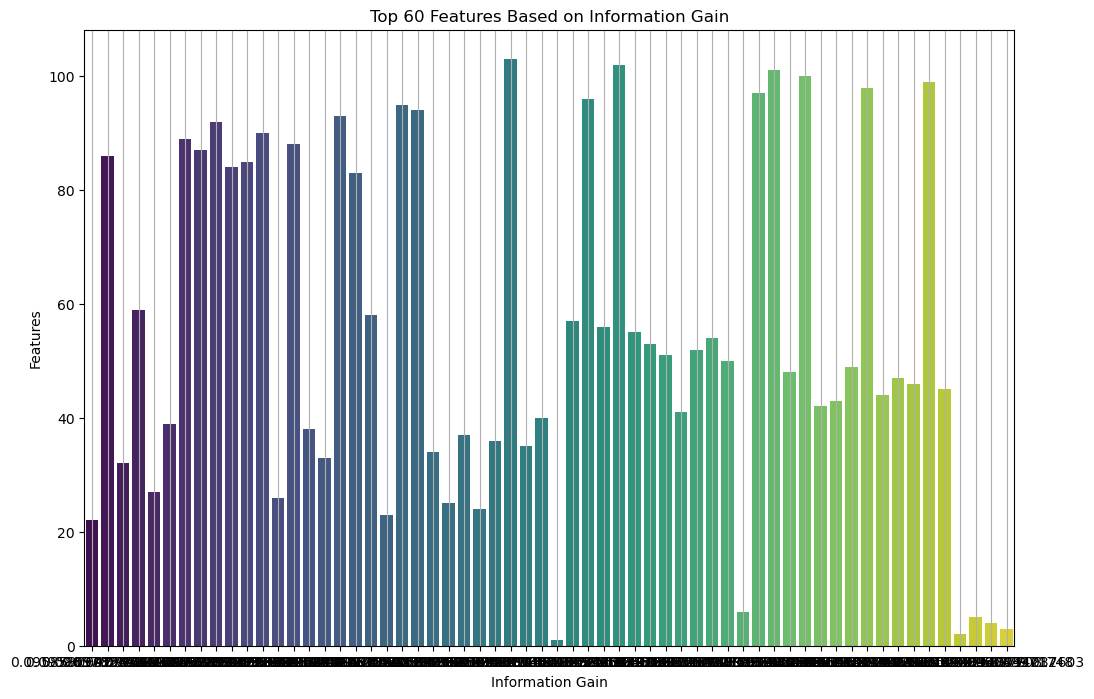

In [41]:
# Select top features for visualization
top_n = 60  # Set to 60 to select the top 60 features
top_features = info_gain_df.head(top_n)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Information Gain', y='Feature', data=top_features, palette='viridis')
plt.title('Top 60 Features Based on Information Gain')
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

## Selected Feature using information Gain

In [42]:
info_gain = mutual_info_classif(X, y, discrete_features='auto')

# Create a DataFrame to display features and their corresponding Information Gain
info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})

# Sort and select top 60 features
top_features = info_gain_df.sort_values(by='Information Gain', ascending=False).head(60)
top_feature_names = top_features['Feature'].values
print(top_feature_names)

[  3   4   5   2  45  47  46  99  44  49  43  98  42 100  48 101   6  97
  50  54 102  52  51  41  55  53  56  96  40  35  57   1  36  24  37 103
  25  94  58  34  95  23  33  89  38  93  83  26  88  90  84  87  85  27
  92  39  59  32  91  86]


## Splitting the dataset into training and test sets

In [43]:
# Filter the dataset to only include top features
X_top = X[top_feature_names]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for LSTM and CNN-LSTM (3D array for LSTM)
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## CNN model Definition

In [44]:
# CNN Model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    return model

## LSTM model Definition

In [45]:
# LSTM Model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    return model

## CNN-LSTM model Definition

In [47]:
# CNN-LSTM Model
def create_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    return model

In [48]:
cnn_model = create_cnn_model((X_train.shape[1], 1))

In [49]:
lstm_model = create_lstm_model((X_train_lstm.shape[1], 1))

In [50]:
cnn_lstm_model = create_cnn_lstm_model((X_train_lstm.shape[1], 1))

In [53]:
# Compile models
cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_lstm_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
# Train models
cnn_history = cnn_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, 
                             validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
2189/2189 [==============================] - 6s 2ms/step - loss: 0.2786 - accuracy: 0.9249 - val_loss: 0.1654 - val_accuracy: 0.9540
Epoch 2/20
2189/2189 [==============================] - 6s 3ms/step - loss: 0.1932 - accuracy: 0.9481 - val_loss: 0.1472 - val_accuracy: 0.9581
Epoch 3/20
2189/2189 [==============================] - 6s 3ms/step - loss: 0.1732 - accuracy: 0.9532 - val_loss: 0.1370 - val_accuracy: 0.9623
Epoch 4/20
2189/2189 [==============================] - 8s 4ms/step - loss: 0.1607 - accuracy: 0.9558 - val_loss: 0.1286 - val_accuracy: 0.9628
Epoch 5/20
2189/2189 [==============================] - 7s 3ms/step - loss: 0.1534 - accuracy: 0.9577 - val_loss: 0.1247 - val_accuracy: 0.9643
Epoch 6/20
2189/2189 [==============================] - 6s 3ms/step - loss: 0.1438 - accuracy: 0.9597 - val_loss: 0.1165 - val_accuracy: 0.9663
Epoch 7/20
2189/2189 [==============================] - 7s 3ms/step - loss: 0.1385 - accuracy: 0.9611 - val_loss: 0.1102 - val_accuracy:

In [55]:
lstm_history = lstm_model.fit(X_train_lstm, y_train, 
                               validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
2189/2189 [==============================] - 40s 17ms/step - loss: 0.5520 - accuracy: 0.8253 - val_loss: 0.5762 - val_accuracy: 0.8262
Epoch 2/20
2189/2189 [==============================] - 39s 18ms/step - loss: 0.5064 - accuracy: 0.8384 - val_loss: 0.4495 - val_accuracy: 0.8476
Epoch 3/20
2189/2189 [==============================] - 38s 17ms/step - loss: 0.4647 - accuracy: 0.8439 - val_loss: 0.4213 - val_accuracy: 0.8584
Epoch 4/20
2189/2189 [==============================] - 38s 17ms/step - loss: 0.4296 - accuracy: 0.8591 - val_loss: 0.3660 - val_accuracy: 0.8834
Epoch 5/20
2189/2189 [==============================] - 39s 18ms/step - loss: 0.3967 - accuracy: 0.8780 - val_loss: 0.3406 - val_accuracy: 0.9057
Epoch 6/20
2189/2189 [==============================] - 38s 17ms/step - loss: 0.3672 - accuracy: 0.8921 - val_loss: 0.3194 - val_accuracy: 0.9099
Epoch 7/20
2189/2189 [==============================] - 38s 17ms/step - loss: 0.3299 - accuracy: 0.9079 - val_loss: 0.3072 -

In [56]:
cnn_lstm_history = cnn_lstm_model.fit(X_train_lstm, y_train, 
                                       validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
2189/2189 [==============================] - 26s 11ms/step - loss: 0.4536 - accuracy: 0.8768 - val_loss: 0.3254 - val_accuracy: 0.9121
Epoch 2/20
2189/2189 [==============================] - 25s 11ms/step - loss: 0.2944 - accuracy: 0.9230 - val_loss: 0.2229 - val_accuracy: 0.9394
Epoch 3/20
2189/2189 [==============================] - 25s 11ms/step - loss: 0.2357 - accuracy: 0.9363 - val_loss: 0.1900 - val_accuracy: 0.9458
Epoch 4/20
2189/2189 [==============================] - 25s 11ms/step - loss: 0.2044 - accuracy: 0.9439 - val_loss: 0.1713 - val_accuracy: 0.9507
Epoch 5/20
2189/2189 [==============================] - 24s 11ms/step - loss: 0.1839 - accuracy: 0.9500 - val_loss: 0.1672 - val_accuracy: 0.9528
Epoch 6/20
2189/2189 [==============================] - 25s 11ms/step - loss: 0.1697 - accuracy: 0.9537 - val_loss: 0.1530 - val_accuracy: 0.9562
Epoch 7/20
2189/2189 [==============================] - 24s 11ms/step - loss: 0.1591 - accuracy: 0.9570 - val_loss: 0.1426 -

In [57]:
# Evaluate models
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test)
print(f"CNN Test Loss: {cnn_loss:.4f}, Test Accuracy: {cnn_accuracy:.4f}")

lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test)
print(f"LSTM Test Loss: {lstm_loss:.4f}, Test Accuracy: {lstm_accuracy:.4f}")

cnn_lstm_loss, cnn_lstm_accuracy = cnn_lstm_model.evaluate(X_test_lstm, y_test)
print(f"CNN-LSTM Test Loss: {cnn_lstm_loss:.4f}, Test Accuracy: {cnn_lstm_accuracy:.4f}")

685/685 [==============================] - 1s 1ms/step - loss: 0.0945 - accuracy: 0.9761
CNN Test Loss: 0.0945, Test Accuracy: 0.9761
685/685 [==============================] - 5s 8ms/step - loss: 0.1849 - accuracy: 0.9508
LSTM Test Loss: 0.1849, Test Accuracy: 0.9508
685/685 [==============================] - 3s 4ms/step - loss: 0.1127 - accuracy: 0.9705
CNN-LSTM Test Loss: 0.1127, Test Accuracy: 0.9705


In [58]:
# Make predictions for CNN
cnn_y_pred_prob = cnn_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
cnn_y_pred = np.argmax(cnn_y_pred_prob, axis=1)

# Make predictions for LSTM
lstm_y_pred_prob = lstm_model.predict(X_test_lstm)
lstm_y_pred = np.argmax(lstm_y_pred_prob, axis=1)

# Make predictions for CNN-LSTM
cnn_lstm_y_pred_prob = cnn_lstm_model.predict(X_test_lstm)
cnn_lstm_y_pred = np.argmax(cnn_lstm_y_pred_prob, axis=1)

# Function to generate evaluation metrics
def evaluate_model(y_true, y_pred_prob, y_pred, model_name):
    # Classification report
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix for {model_name}:\n", cm)
    
    # AUC-ROC
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    auc_roc = roc_auc_score(y_true_bin, y_pred_prob, multi_class='ovr')
    print(f"AUC-ROC Score for {model_name}: {auc_roc:.4f}")
    
    return cm, auc_roc

685/685 [==============================] - 4s 5ms/step


In [59]:
# Evaluate models
cnn_cm, cnn_auc = evaluate_model(y_test, cnn_y_pred_prob, cnn_y_pred, "CNN")
lstm_cm, lstm_auc = evaluate_model(y_test, lstm_y_pred_prob, lstm_y_pred, "LSTM")
cnn_lstm_cm, cnn_lstm_auc = evaluate_model(y_test, cnn_lstm_y_pred_prob, cnn_lstm_y_pred, "CNN-LSTM")

Classification Report for CNN:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18160
         1.0       0.95      0.62      0.75       535
         2.0       0.95      0.91      0.93      1402
         3.0       0.92      0.68      0.78       158
         4.0       0.98      0.96      0.97      1635

    accuracy                           0.98     21890
   macro avg       0.95      0.83      0.88     21890
weighted avg       0.98      0.98      0.97     21890

Confusion Matrix for CNN:
 [[18073    18    35     4    30]
 [  180   334    16     0     5]
 [  115     1  1276     5     5]
 [   37     0    14   107     0]
 [   51     0     8     0  1576]]
AUC-ROC Score for CNN: 0.9826
Classification Report for LSTM:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     18160
         1.0       0.95      0.45      0.61       535
         2.0       0.90      0.76      0.83      1402
      

In [60]:
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues,
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

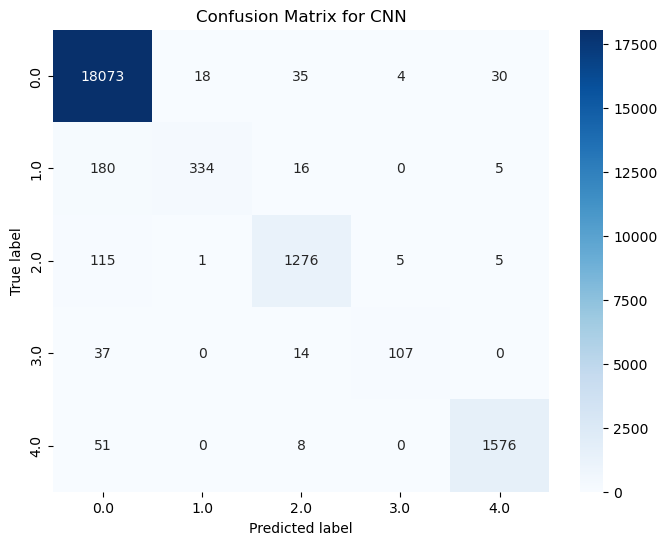

In [61]:
# Class names based on your dataset (update as necessary)
class_names = np.unique(y)

# Plot confusion matrices
plot_confusion_matrix(cnn_cm, class_names, "CNN")

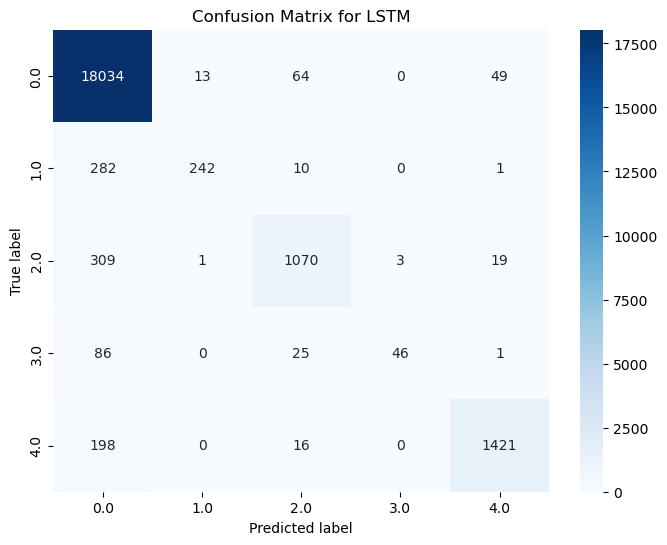

In [62]:
plot_confusion_matrix(lstm_cm, class_names, "LSTM")

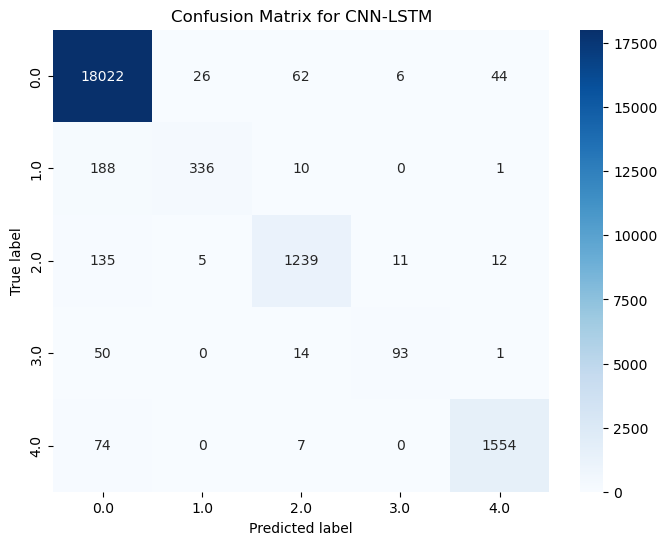

In [63]:
plot_confusion_matrix(cnn_lstm_cm, class_names, "CNN-LSTM")

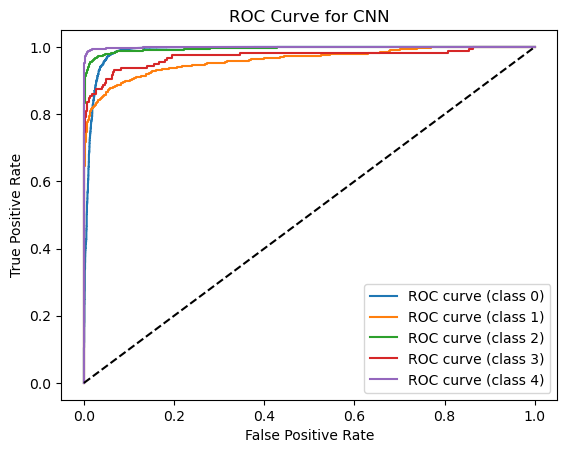

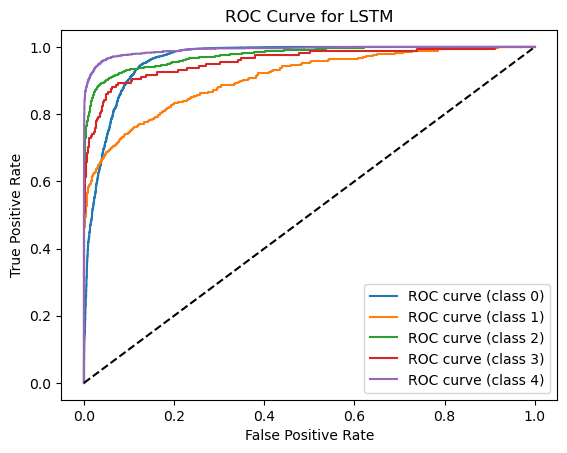

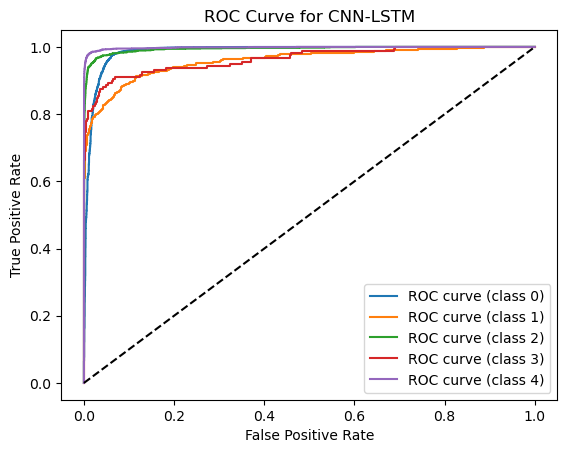

In [66]:
def plot_roc_curve(y_true_bin, y_pred_prob, model_name):
    plt.figure()
    for i in range(len(np.unique(y))):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve (class {i})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Binarize the test labels for ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# Plot ROC curves
plot_roc_curve(y_test_bin, cnn_y_pred_prob, "CNN")
plot_roc_curve(y_test_bin, lstm_y_pred_prob, "LSTM")
plot_roc_curve(y_test_bin, cnn_lstm_y_pred_prob, "CNN-LSTM")

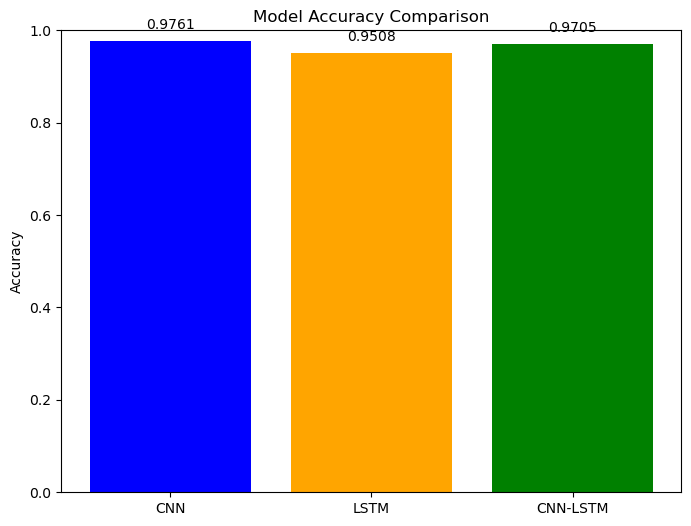

In [68]:
# Bar chart to compare accuracies with scores on top
accuracies = [cnn_accuracy, lstm_accuracy, cnn_lstm_accuracy]
model_names = ['CNN', 'LSTM', 'CNN-LSTM']

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies, color=['blue', 'orange', 'green'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Adding text annotations to display accuracy scores on top of each bar
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{acc:.4f}', ha='center', va='bottom')

plt.show()